In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matrixprofile import *

In [31]:
def load_npy(filename):
    return np.load(filename)


dir_path = 'dataset/cleaned_time_series/'
len_threshold = 1280
X, y, ids = [], [], []

for file in os.listdir(dir_path):
    if os.path.splitext(file)[1] != '.npy':
        continue

    split = file.split("_")
    ids.append(split[0])  # track_id
    y.append(split[1][:-4])  # genre
    ts = load_npy(dir_path + file)

    if len(ts) > len_threshold:
        ts = ts[0:len_threshold]
    else:
        # pad = [np.mean(ts[:-5])] * (len_threshold-len(ts)) # fill by mean value of last n observations
        pad = [ts[-1]] * (len_threshold - len(ts))  # fill with last observation
        ts = np.append(ts, pad)

    X.append([ts])

X, y, ids = np.array(X), np.array(y), np.array(ids)

**Analysis of the dataset to find motifs and/or anomalies**

# Matrix Profile
• The Matrix Profile (MP) is a data structure that annotates a TS and
can be exploited for many purposed: e.g. efficient Motif Discovery.

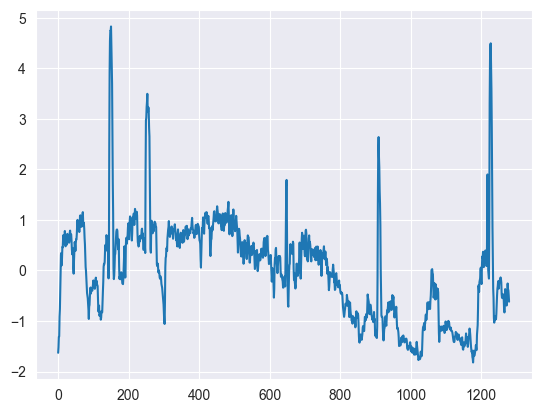

In [10]:
plt.plot(X[0,-1].T)
plt.show()

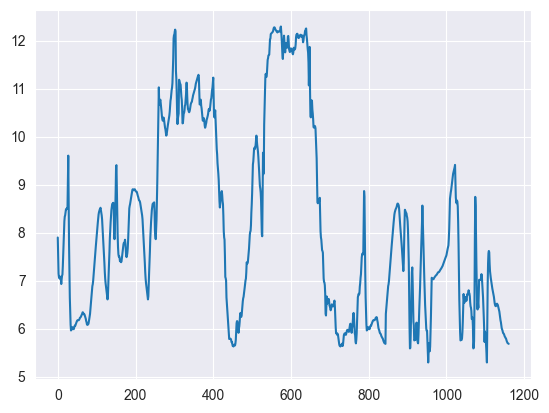

In [28]:
w = 120
ts = pd.Series(X[0,-1].T)
mp, mpi = matrixProfile.stomp(ts.values, w)
'''
The function *stomp* returns two arrays:
mp (Matrix Profile): An array where each element represents the smallest distance between a subsequence in the time series and its nearest, non-trivial matching subsequence.
mpi (Matrix Profile Index): An array of the indices where these minimum distances occur.
'''
plt.plot(mp)
plt.show()